This demo is based on  <a href="https://www.kaggle.com/c/tgs-salt-identification-challenge" target="_blank">TGS Salt Identification Challenge</a>

In [127]:
!pip install tensorflow

In [128]:
!pip install keras

In [129]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import Lambda, RepeatVector, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [130]:


# Set some parameters
im_width = 128
im_height = 128
border = 5

path = 'C:/Users/I344960/Desktop/test/assignment_dataset/train/image'


In [131]:


ids = next(os.walk('C:/Users/I344960/Desktop/test/assignment_dataset/train/image'))[2] # list of names all images in the given path
print("No. of images = ", len(ids))


No. of images =  30


In [132]:
print(ids)

['11.jpg', '13.jpg', '15.jpg', '16.jpg', '17.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg', '32.jpg', '35.jpg', '38.jpg', '39.jpg', '41.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '5.jpg', '7.jpg', '8.jpg']


In [133]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [134]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("C:/Users/I344960/Desktop/test/assignment_dataset/train/image/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("C:/Users/I344960/Desktop/test/assignment_dataset/train/image/"+id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

C:\Users\I344960\AppData\Local\Temp\ipykernel_3884\1327770304.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):


  0%|          | 0/30 [00:00<?, ?it/s]

c:\Users\I344960\AppData\Local\anaconda3\lib\site-packages\keras\src\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [135]:


# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)



In [136]:
print(X_train.shape)

(27, 128, 128, 1)


In [137]:
print(y_valid.shape)

(3, 128, 128, 1)


In [138]:
from PIL import Image

image1 = Image.open('C:/Users/I344960/Desktop/test/assignment_dataset/train/image/5.jpg')
image1.show()



In [139]:
image2 = Image.open('C:/Users/I344960/Desktop/test/assignment_dataset/train/image/7.jpg')
image2.show()

Text(0.5, 1.0, 'non powerline')

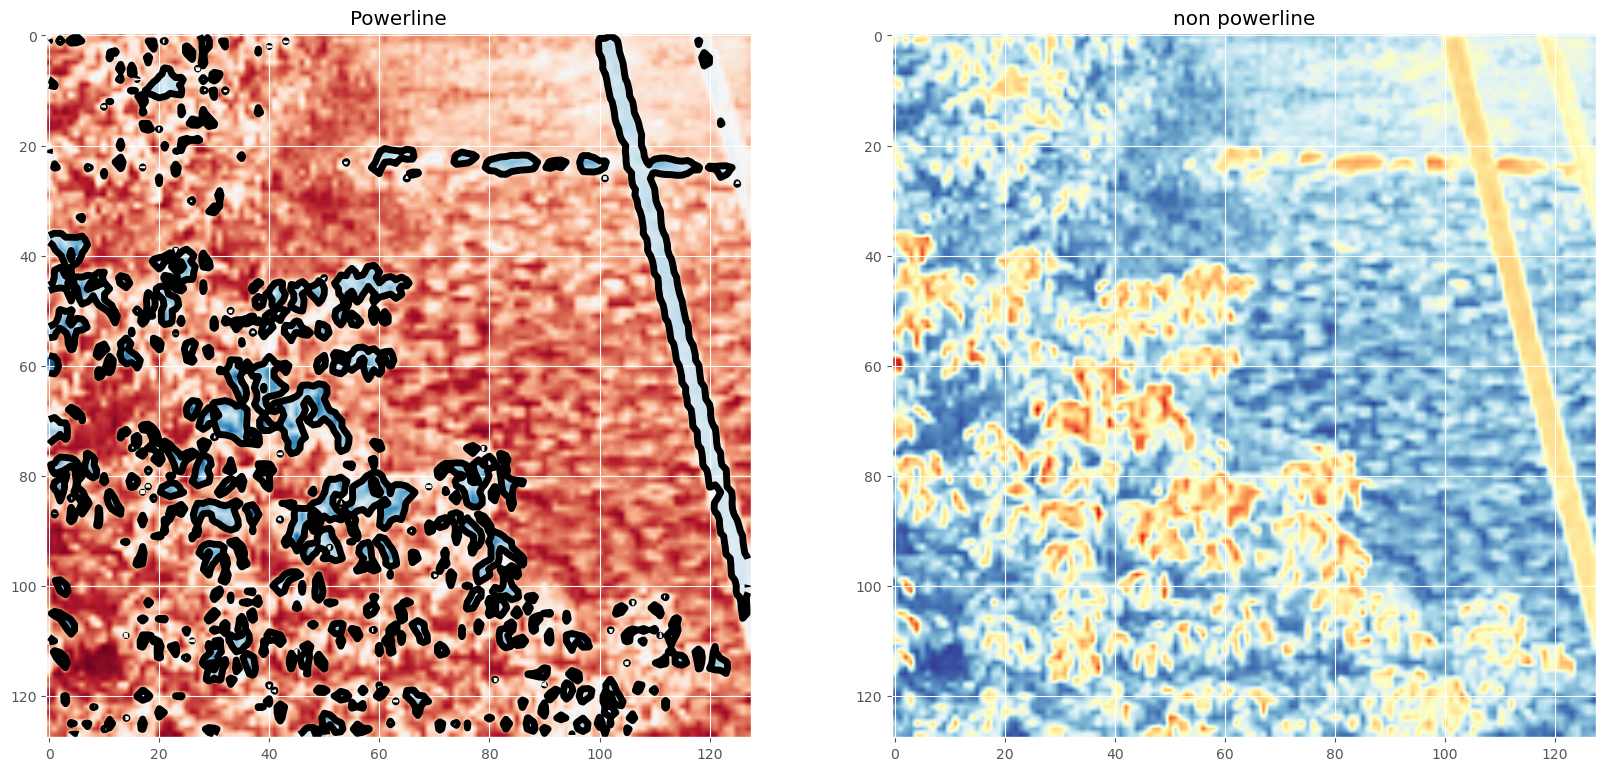

In [140]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # powerline indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))
# RdYlBu_r
ax1.imshow(X_train[ix, ..., 0], cmap = 'RdBu', interpolation = 'bilinear')
if has_mask: # if powerline
    # draw a boundary(contour) in the original image separating powerline and non-powerline areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Powerline')
#'gray'
#'Greens'
ax2.imshow(y_train[ix].squeeze(), cmap = 'RdYlBu_r', interpolation = 'bilinear')
ax2.set_title('non powerline')

In [141]:


def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x



In [142]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [143]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [144]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_39 (Conv2D)          (None, 128, 128, 16)         160       ['img[0][0]']                 
                                                                                                  
 batch_normalization_37 (Ba  (None, 128, 128, 16)         64        ['conv2d_39[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_37 (Activation)  (None, 128, 128, 16)         0         ['batch_normalization_37

In [145]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-powerline.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [146]:
results = model.fit(X_train, y_train, batch_size=32, epochs=2, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1/1 [==============================] - ETA: 0s - loss: 0.8486 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 0.81064, saving model to model-tgs-powerline.h5
1/1 [==============================] - 15s 15s/step - loss: 0.8486 - accuracy: 0.0000e+00 - val_loss: 0.8106 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/2
1/1 [==============================] - ETA: 0s - loss: 0.8163 - accuracy: 0.0000e+00
Epoch 2: val_loss did not improve from 0.81064
1/1 [==============================] - 2s 2s/step - loss: 0.8163 - accuracy: 0.0000e+00 - val_loss: 0.8459 - val_accuracy: 0.0000e+00 - lr: 0.0010


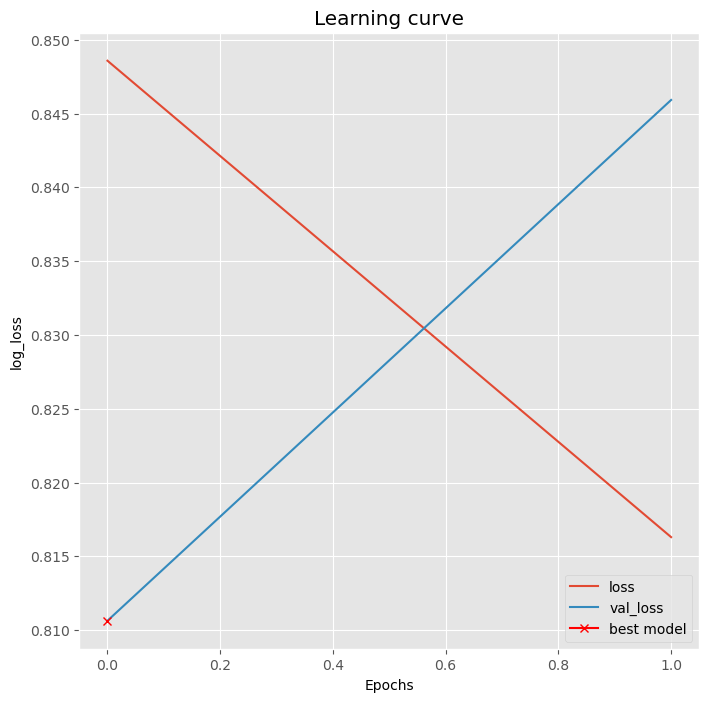

In [147]:


plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();



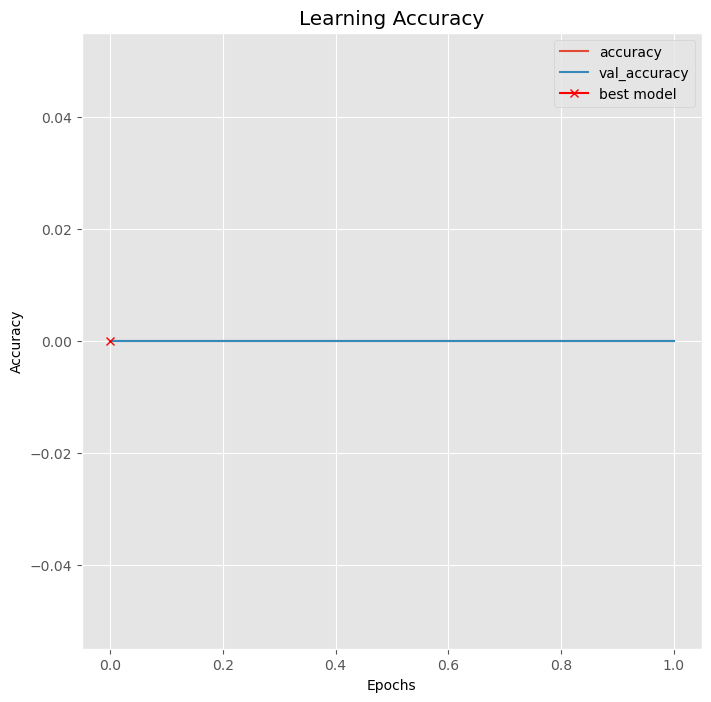

In [148]:
plt.figure(figsize=(8, 8))
plt.title("Learning Accuracy")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmin(results.history["val_accuracy"]), np.min(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [149]:
# load the best model
model.load_weights('model-tgs-powerline.h5')

In [150]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 0s 108ms/step - loss: 0.8106 - accuracy: 0.0000e+00


[0.8106368184089661, 0.0]

In [151]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

1/1 [==============================] - 0s 117ms/step


In [152]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [153]:


def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='RdBu')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), levels=[0.5])
    ax[0].set_title('gray')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Powerline')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), levels=[0.5])
    ax[2].set_title('Powerline Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), levels=[0.5])
    ax[3].set_title('Powerline Predicted binary');



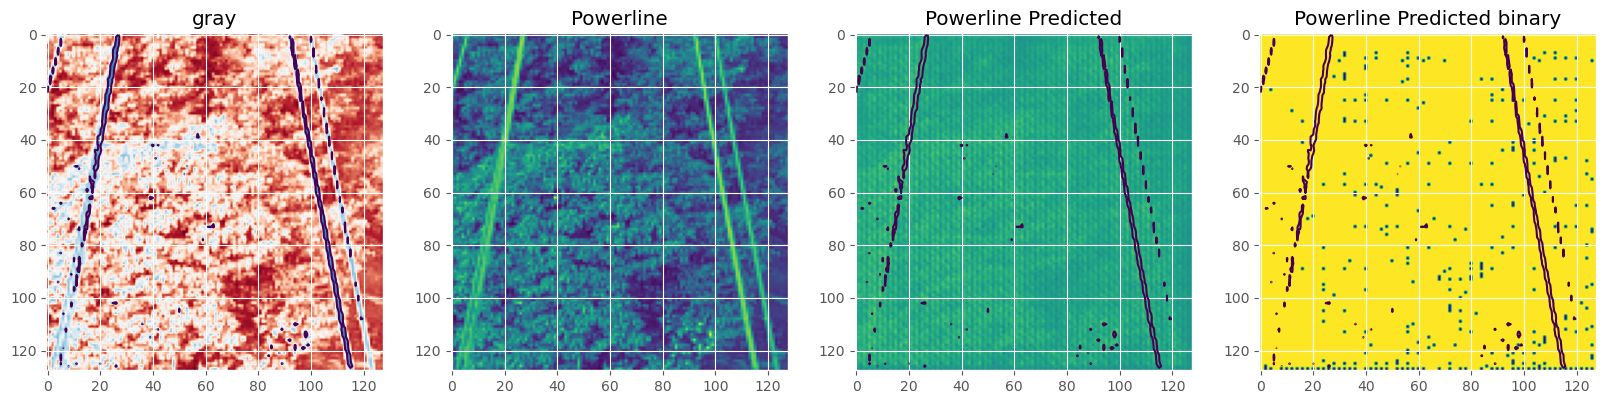

In [154]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

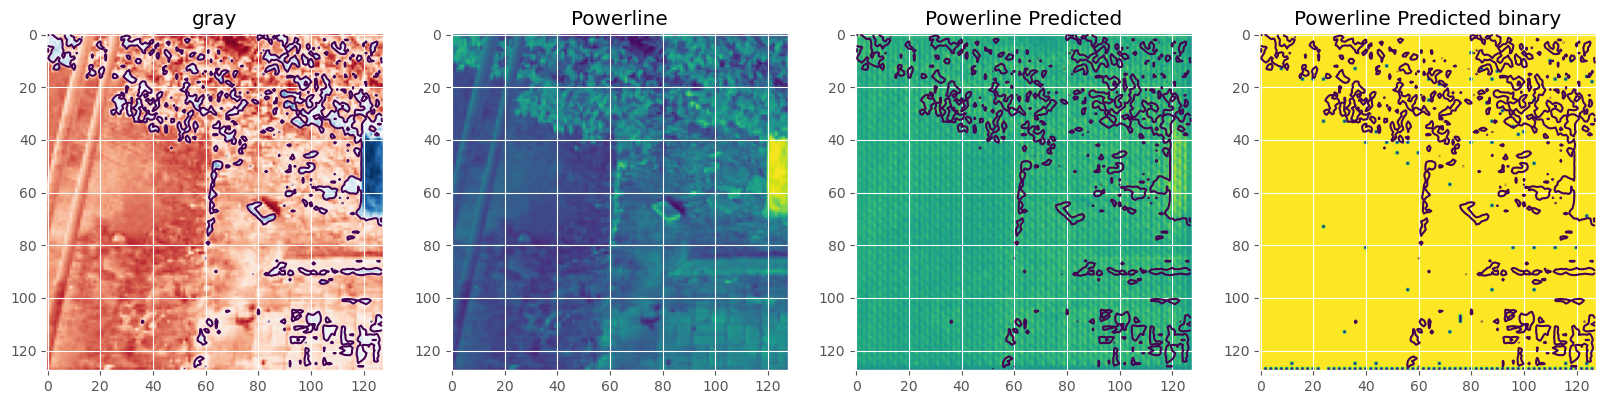

In [155]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

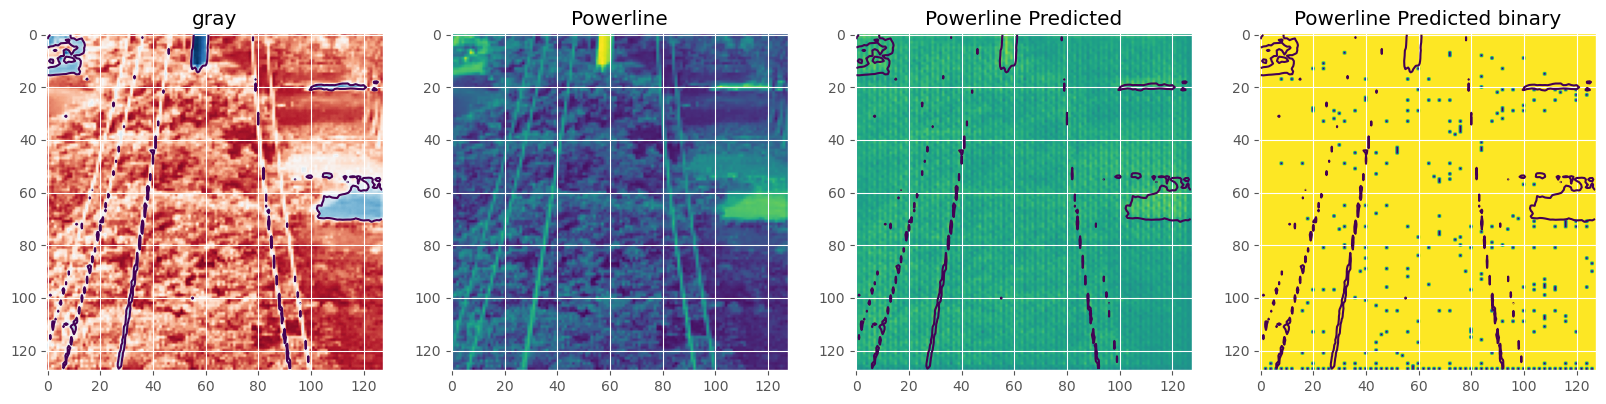

In [156]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

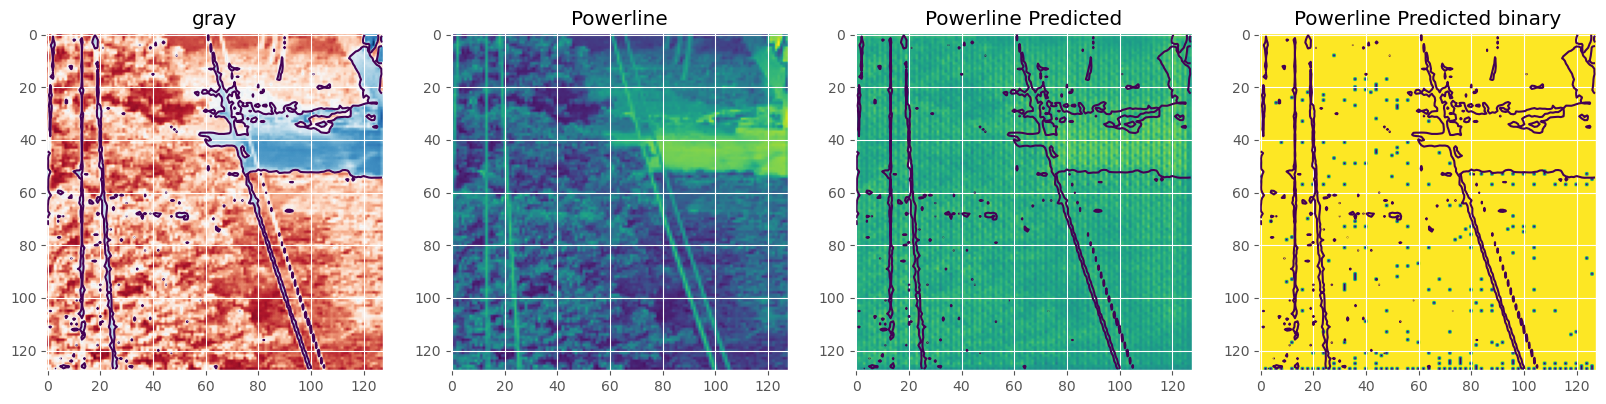

In [157]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

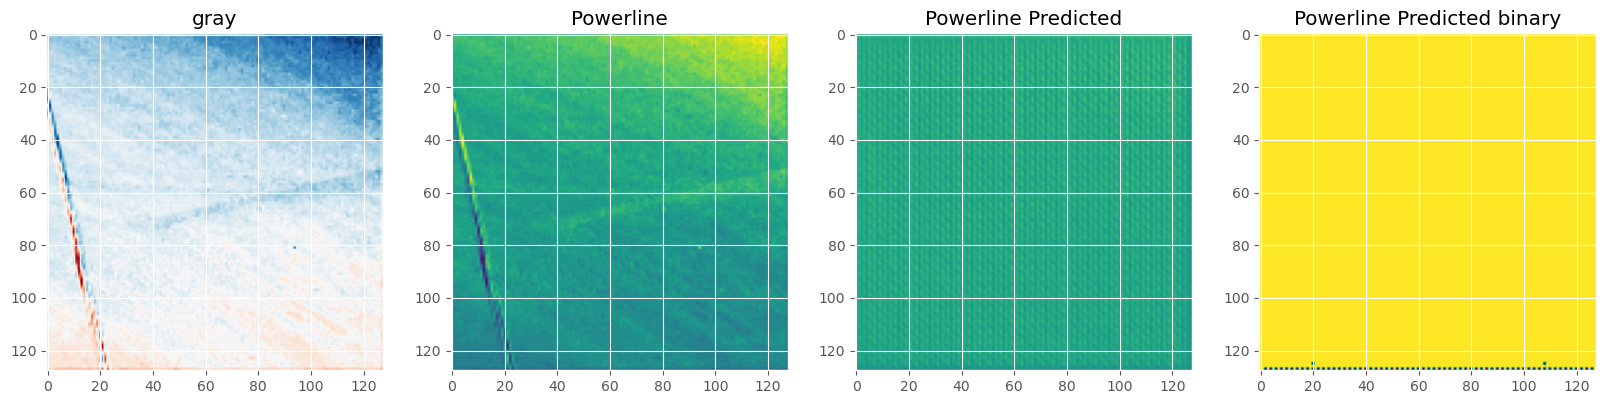

In [158]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

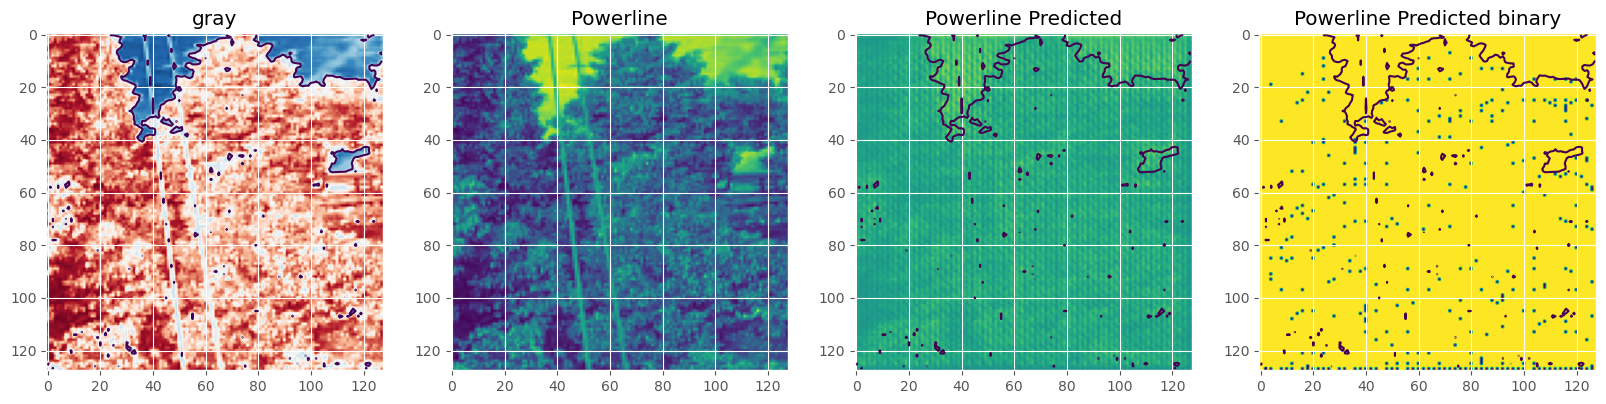

In [159]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

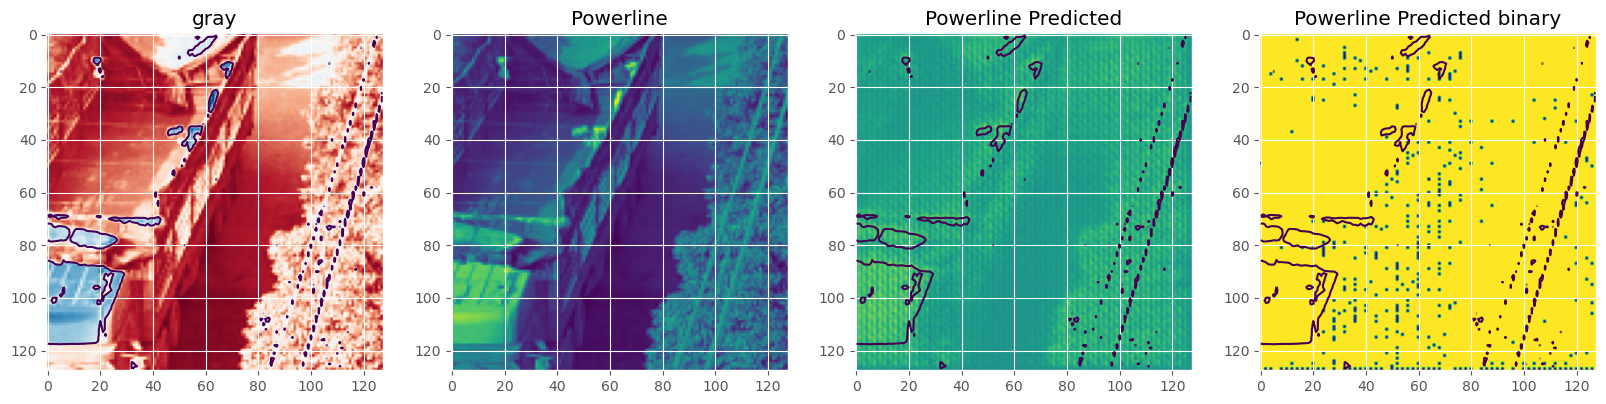

In [160]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

Predictions on test set

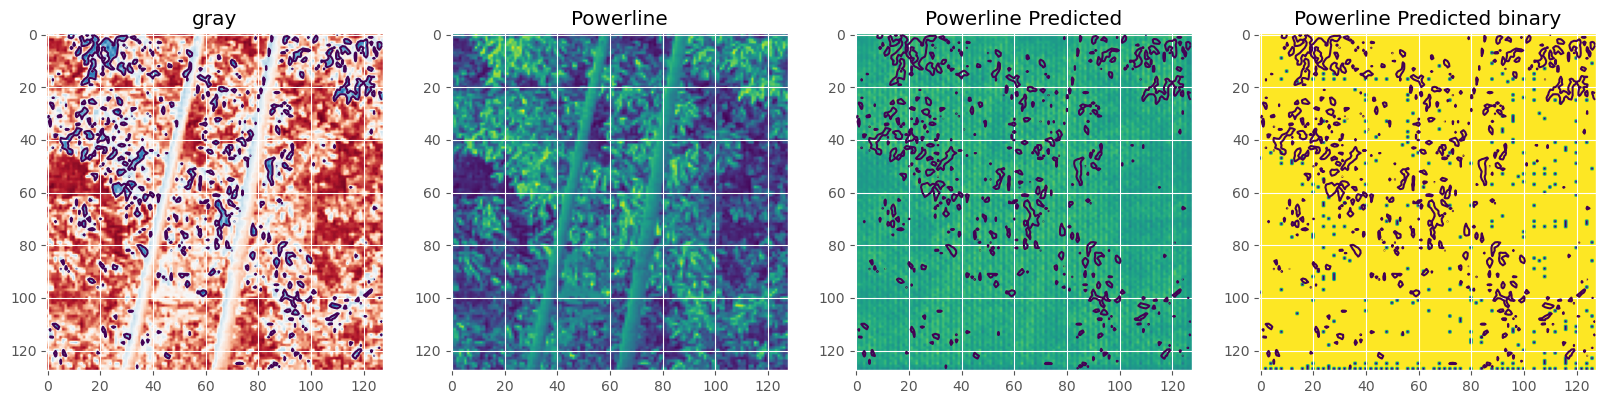

In [164]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=2)